<a href="https://colab.research.google.com/github/a123700/Leo/blob/master/Reinforcement_Learning_with_a2c_structure_for_Stock_Market_Trading.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Stage 1: Installing dependencies and environment setup


In [1]:
api_token = {"username":"srhgccc","key":"41c36ccc1ee7bc07f70e459ccbf7df7c"}
import json
import zipfile
import os
 
if not os.path.exists("/root/.kaggle"):
    os.makedirs("/root/.kaggle")
 
with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)
!chmod 600 /root/.kaggle/kaggle.json
 
if not os.path.exists("/kaggle"):
    os.makedirs("/kaggle")
os.chdir('/kaggle')

In [2]:
!kaggle datasets download -d srhgccc/reinforcement-learning-model-for-stock-trading
!unzip reinforcement-learning-model-for-stock-trading.zip

 76% 5.00M/6.62M [00:00<00:00, 47.4MB/s]
100% 6.62M/6.62M [00:00<00:00, 59.4MB/s]
Archive:  reinforcement-learning-model-for-stock-trading.zip
  inflating: TWII_ai_trader.h5       


In [3]:
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



## Stage 2: Importing project dependencies

In [4]:
import math
import random
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Layer
from tensorflow.keras.models import Model
from tensorflow import keras
from tensorflow.keras import layers
from scipy.special import softmax

from tqdm import tqdm
from tqdm.contrib import tzip
from collections import deque
import warnings
warnings.filterwarnings('ignore')
import time
from google.colab import files
from IPython.display import clear_output

## Stage 3: Building the AI Trader network

### Time Embedding

In [5]:
'''
Time Embedding takes the data feature values of the time-series (ie. stock prices) as input, 
not the 'time' values (ie. date-month-year eg. 02-04-1972).

Hence, in the Embedding formula, above, the input value, τ, corresponds to the stock price.
The 'i' and 'k' corresponds to the size of embedding dimension.

The Embedding has a dimension of two (ie. k == 2 in the formula): 
   The first dimension (ie. i == 0) is the 'non-periodic' or 'linear' feature ie. ωᵢτ + φᵢ
   The second dimension (ie. i == 1) is the 'periodic' feature ie. F(ωᵢτ + φᵢ)
   NB: We could have additional dimensions ie. third, fourth etc by adding more periodic features
       with different weights

The linear feature (ie. t2v(τ) = ωᵢτ + φᵢ) is just a straight line formula (ie. y = mᵢx + bᵢ), 
   where ω is the slope and φ is the y-intercept, as shown in the gra
For the periodic feature, the linear function (ωᵢτ + φᵢ) is wrapped in an additional function F(). 
   This F() can be any function (eg. sin, cos, relu...). Here we use sine, where φ shifts the sine 
   function along the x-axis and ω determines the wavelength of the sine function, as shown in the
   graph above.
'''

class Time2Vector(Layer):
  def __init__(self, seq_len, **kwargs):
    super(Time2Vector, self).__init__()
    self.seq_len = seq_len

  def build(self, input_shape):
    '''Initialize weights and biases with shape (batch, seq_len)'''
    # initiate 4 matrices, 2 for ω and 2 forφ since we need aω and φ matrix for 
    # both non-periodical (linear) and the periodical (sin) features.
    self.weights_linear = self.add_weight(name='weight_linear',
                                shape=(int(self.seq_len),),
                                initializer='uniform',
                                trainable=True)
    
    self.bias_linear = self.add_weight(name='bias_linear',
                                shape=(int(self.seq_len),),
                                initializer='uniform',
                                trainable=True)
    
    self.weights_periodic = self.add_weight(name='weight_periodic',
                                shape=(int(self.seq_len),),
                                initializer='uniform',
                                trainable=True)

    self.bias_periodic = self.add_weight(name='bias_periodic',
                                shape=(int(self.seq_len),),
                                initializer='uniform',
                                trainable=True)
  
  def call(self, x):
    '''Calculate linear and periodic time features'''

    # Exclude Volume and average across the Open, High, Low, and Close prices, resulting 
    # in the shape (batch_size, seq_len)
    x = tf.math.reduce_mean(x[:,:,:4], axis=-1)

    # calculate the non-periodic (linear) time feature and expand the dimension by 1 again ie. (batch_size, seq_len, 1)
    time_linear = self.weights_linear * x + self.bias_linear # Linear time feature
    time_linear = tf.expand_dims(time_linear, axis=-1) # Add dimension (batch, seq_len, 1)
    
    # repeat for the periodic time feature, also resulting in the same matrix shape. (batch_size, seq_len, 1)
    time_periodic = tf.math.sin(tf.multiply(x, self.weights_periodic) + self.bias_periodic)
    time_periodic = tf.expand_dims(time_periodic, axis=-1) # Add dimension (batch, seq_len, 1)

    # concatenate the linear and periodic time feature. (batch_size, seq_len, 2)
    return tf.concat([time_linear, time_periodic], axis=-1) # shape = (batch, seq_len, 2)
   
  def get_config(self): # Needed for saving and loading model with custom layer
    config = super(Time2Vector, self).get_config().copy()
    config.update({'seq_len': self.seq_len})
    return config

### Custom learning rate

In [6]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=4000):
    super().__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    step = tf.cast(step, dtype=tf.float32)
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

  def get_config(self):
    config = {
    'd_model': self.d_model.numpy(),
    'warmup_steps': self.warmup_steps,
     }
    return config

### Transformer encoder

In [7]:
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Normalization and Attention
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(x, x)
    x = layers.Dropout(dropout)(x)
    res = x + inputs

    # Feed Forward Part
    x = layers.LayerNormalization(epsilon=1e-6)(res)
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    return x + res

### Trader Structure

In [8]:
class AI_Trader():
  def __init__(self, state_size, maxlen, model = None, action_space=3, model_name="AITrader", d_rate = 0.95): #Stay, Buy, Sell
    
    self.state_size = state_size
    self.action_space = action_space
    self.memory = deque(maxlen=maxlen)
    self.action_reward = []
    self.long_inventory = []
    self.short_inventory = []
    self.net_capital = []
    self.model_name = model_name
    
    # Define hyperparamaters
    self.gamma = d_rate
    self.epsilon = 1.0
    self.epsilon_final = 0.01
    self.epsilon_decay = 0.95
  
    if model == None:
      self.model = self.model_builder(    
      input_shape=(state_size, 1),
      head_size=256,
      num_heads=10,
      ff_dim=5,
      num_transformer_blocks=20,
      mlp_units=[512, 256, 128, 64, 32, 16, 8],
      mlp_dropout=0,
      dropout=0)
    else:
      self.model = tf.keras.models.load_model(model, custom_objects={'Time2Vector':Time2Vector, 'CustomSchedule':CustomSchedule})
      
  def reset(self):
    self.long_inventory = []
    self.short_inventory = []
    self.net_capital = []
    self.action_reward = []

  def model_builder(self, 
    head_size,
    num_heads,
    ff_dim,
    num_transformer_blocks,
    mlp_units,
    input_shape,
    dropout=0,
    mlp_dropout=0):
    input1 = keras.Input(shape=input_shape)
    x = input1
    time_embedding = Time2Vector(window_size)
    x = time_embedding(x)
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(mlp_dropout)(x)
    x = layers.Dense(16, activation="relu")(x)

    input2 = layers.Input(shape=(1))
    input3 = layers.Input(shape=(1))
    input4 = layers.Input(shape=(1))

    x = layers.Concatenate()([x, input2, input3, input4])
    actor = layers.Dense(units = 32, activation='relu')(x)
    actor = layers.Dense(units = 16, activation='relu')(actor)
    actor = layers.Dense(units = 8, activation='relu')(actor)
    output1 = layers.Dense(units=self.action_space, activation='softmax')(actor)

    critic = layers.Dense(units = 32, activation='relu')(x)
    critic = layers.Dense(units = 16, activation='relu')(critic)
    critic = layers.Dense(units = 8, activation='relu')(critic)
    output2 = layers.Dense(units=1, activation='linear')(critic)

    model = Model(inputs = [input1, input2, input3, input4], outputs = [output1, output2], name = self.model_name)
    model.compile(loss=['categorical_crossentropy', 'mse'], optimizer=optimizer)
    return model

  def performace_calculate(self, data, y, window_size, episodes, budget, data_samples, batch_size, trade_training_process):
    for episode in range(1, episodes + 1):
      start = time.time()
      long_time = []
      short_time = []
      clear_output(wait=True)
      print("Episode: {}/{}".format(episode, episodes))
      
      # Create state
      state = state_creator(data, window_size, window_size + 1).reshape(1, -1)
      
      total_profit = 0
      # Reset before starting episode
      AI_Trader.reset(self)
      holding_times = 0

      if episode % 20 == 0:
        model_name = "{}_ai_trader_{}.h5".format(stock_name, episode)
        self.model.save(model_name)

      for t in range(window_size, data_samples):
        emotion = np.array(0).reshape(-1, 1)
        long_position = np.array(len(self.long_inventory)).reshape(-1, 1)
        short_position = np.array(len(self.short_inventory)).reshape(-1, 1)
        action, expectation = AI_Trader.trade(self, state, emotion, long_position, short_position)

        reward = 0

        if len(self.long_inventory) > 0:
          emotion = np.array(sum(-np.array(self.long_inventory) + y[t])).reshape(-1, 1)
        
        if len(self.short_inventory) > 0:
          emotion = np.array(sum(np.array(self.short_inventory) - y[t])).reshape(-1, 1)

        
        if action == 0 and len(self.long_inventory) < budget and len(self.short_inventory) == 0: 
          self.long_inventory.append(y[t])
          reward = 10
          holding_times = 0
          long_time.append(t)
          # print("\nAt {}/{}, AI Trader bought: ".format(t+1, data_samples), stocks_price_format(y[t]), ', Long Position Inventory: ', len(trader.long_inventory), ', Unrealized profit $', int(emotion))
          
        elif action == 0 and len(self.long_inventory) == 0 and len(self.short_inventory) > 0: 
          sell_price = self.short_inventory.pop(0)
          long_time.append(t)

          p = sell_price - y[t]
          reward = p - expectation
          holding_times = 0
          total_profit += p
          # print("\nAt {}/{}, AI Trader closed position: ".format(t+1, data_samples), stocks_price_format(y[t]), " Profit: " + stocks_price_format(p), " Current Profit: " + stocks_price_format(total_profit), ', Unrealized profit $', int(emotion))

        elif action == 1 and len(self.long_inventory) > 0: 
          buy_price = self.long_inventory.pop(0)
          holding_times = 0
          short_time.append(t)
          p = y[t] - buy_price 
          reward = p - expectation
          total_profit += p
          # print("\nAt {}/{}, AI Trader sold: ".format(t+1, data_samples), stocks_price_format(y[t]), " Profit: " + stocks_price_format(p), " Current Profit: " + stocks_price_format(total_profit), ', Unrealized profit $' , int(emotion))
        
        elif action == 1 and len(self.short_inventory) < budget and len(self.long_inventory) == 0: 
          self.short_inventory.append(y[t])
          holding_times = 0
          reward = 2
          short_time.append(t)
          # print("\nAt {}/{}, AI Trader shorted: ".format(t+1, data_samples), stocks_price_format(y[t]), ', Short Position Inventory: ', len(trader.short_inventory), ', Unrealized profit $', int(emotion))

        else:
          # print("\nAt {}/{}, AI Trader held. ".format(t+1, data_samples), " Current Profit: " + stocks_price_format(total_profit), ', Unrealized profit $', int(emotion))
          holding_times += 1
          reward = -1000
          

        if t == data_samples - 1:
          done = True
          final_p = 0
          if len(self.long_inventory) > 0:
            for i in self.long_inventory:
              final_p += y[t] - i
          elif len(self.short_inventory) > 0:
            for i in self.short_inventory:
              final_p += i - y[t]
          total_profit += final_p
          # print("\nClosed Profit {} ".format(stocks_price_format(final_p)), " Current Profit: " + stocks_price_format(float(total_profit)))
          reward += final_p
        else:
          done = False
          
        self.net_capital.append(total_profit)
        next_state = state_creator(data, t+1, window_size + 1).reshape(1, -1)

        self.memory.append((state, action, next_state, emotion, long_position, short_position, done))
        self.action_reward.append(reward)
        
        state = next_state
        
        if done:
          print("########################")
          print("TOTAL PROFIT: {}. Time taken for 1 episode: {} secs".format(stocks_price_format(float(total_profit)), round(time.time() - start, 2)))
          print("########################")
          trade_training_process.append(total_profit)
          plt.figure(figsize=(12, 6))
          plt.plot(self.net_capital)
          plt.title('Net Capital')
          plt.ylabel('Capital')
          plt.xlabel('Epochs')
          plt.show()

          plt.figure(figsize=(12, 6))
          plt.plot(y.values, color = 'blue', label = stock_name, lw=2.)  
          plt.plot(y.values, '^', markersize=5, color='red', label = 'buying signal', markevery = long_time)
          plt.plot(y.values, 'v', markersize=5, color='green', label = 'selling signal', markevery = short_time)
          plt.xlabel('Time')
          plt.legend()
          plt.show()

        if len(self.memory) >= batch_size:
          AI_Trader.batch_train(self)
 
  def trade(self, state, emotion, long_position, short_position):
    actions, expectation = self.model.predict([state, emotion, long_position, short_position], verbose = 0)
    if random.random() <= self.epsilon:
      return random.randrange(self.action_space), expectation
    
    actions = np.random.choice(np.arange(self.action_space), size = 1, replace = False, p = actions[0])
    return actions, expectation

  def batch_train(self):
    loss_obj_reg = tf.keras.losses.MeanSquaredError()
    loss_obj_cat = tf.keras.losses.CategoricalCrossentropy()
    discounted_reward = AI_Trader.discounted_reward(self, self.action_reward)
    for i, reward in tzip(self.memory, discounted_reward):
      state, action, next_state, emotion, long_position, short_position, done = i[0], i[1], i[2], i[3], i[4], i[5], i[6]
      total_reward = reward
      target = np.ones((1, self.action_space))
      _, expectation = self.model.predict([state, emotion, long_position, short_position], verbose=0)
      _, expectation1 = self.model.predict([next_state, emotion, long_position, short_position], verbose=0)
      advantage = total_reward - (expectation - expectation1)
      target[0][action] = advantage
      target = softmax(target, axis = 1)
      
      with tf.GradientTape() as tape:
        pred_cat, pred_reg = self.model([state, emotion, long_position, short_position], training=True)
        cat_loss = loss_obj_cat(target, pred_cat)
        reg_loss = loss_obj_reg(total_reward, pred_reg)
      gradients = tape.gradient([cat_loss, reg_loss], self.model.trainable_variables)
      optimizer.apply_gradients(zip(gradients, self.model.trainable_variables))

    self.memory = []

    if self.epsilon > self.epsilon_final:
      self.epsilon *= self.epsilon_decay

  def discounted_reward(self, reward):
    result = []
    for i in range(len(reward)):
      temp = np.array(reward[i:])
      temp1 = np.logspace(0, len(temp), len(temp), base = self.gamma)
      result.append(np.squeeze(temp).dot(np.squeeze(temp1)))
    return result 

## Stage 4: Dataset preprocessing

### Defining helper functions

#### Price format function

In [9]:
def stocks_price_format(n):
  if n < 0:
    return "- $ {:.1f}".format(abs(n))
  else:
    return "$ {:.1f}".format(abs(n))

#### Dataset loader

In [10]:
!pip install -q yfinance --upgrade --no-cache-dir

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.4/51.4 KB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.0/111.0 KB 12.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.2/112.2 KB 134.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.2/128.2 KB 166.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 KB 135.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 83.6 MB/s eta 0:00:00


In [11]:
import yfinance as yf 

def dataset_loader(stock_name, start_time, end_time = None):
  if end_time == None:
    dataset = yf.download(stock_name, start=start_time)['Close'][1:]
    dataset1 = np.log(dataset/dataset.shift(1))
    return dataset, dataset1.dropna()

  else:
    dataset = yf.download(stock_name, start=start_time, end = end_time)['Close'][1:]
    dataset1 = np.log(dataset/dataset.shift(1))
    return dataset, dataset1.dropna()

def high_frequency_dataset_loader(stock_name, period, interval):
  dataset = yf.download(stock_name, period=period, interval=interval)[1:]
  dataset1 = np.log(dataset['Close']/dataset['Close'].shift(1))
  
  return dataset['Open'], dataset1.dropna()

### Loading a training dataset

In [12]:
stock_name = "^TWII"
start_time = '2008-01-01'
end_time = '2010-12-31'

# y, data = dataset_loader(stock_name, start_time = start_time, end_time = end_time)
y, data = high_frequency_dataset_loader(stock_name, period = '3d', interval = '1m')

[*********************100%***********************]  1 of 1 completed


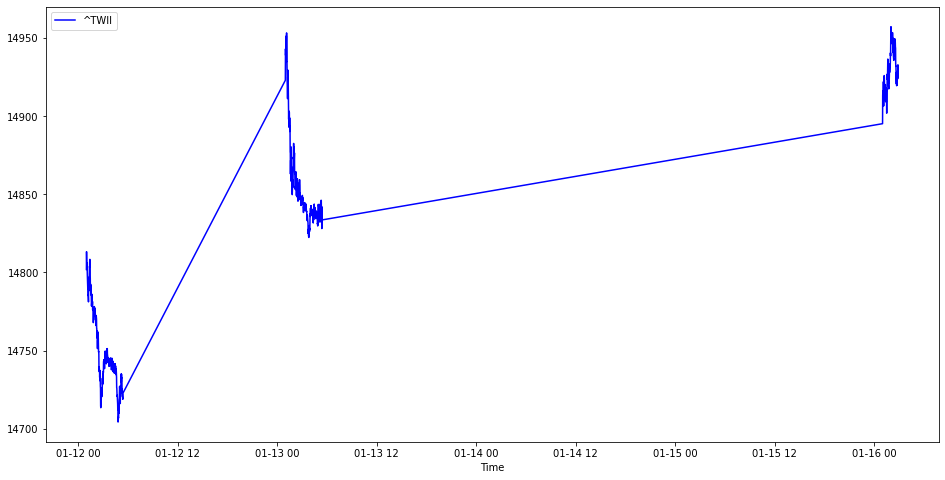

In [13]:
plt.figure(figsize=(16, 8))
plt.plot(y, color = 'blue', label = stock_name)  
plt.xlabel('Time')
plt.legend()
plt.show()

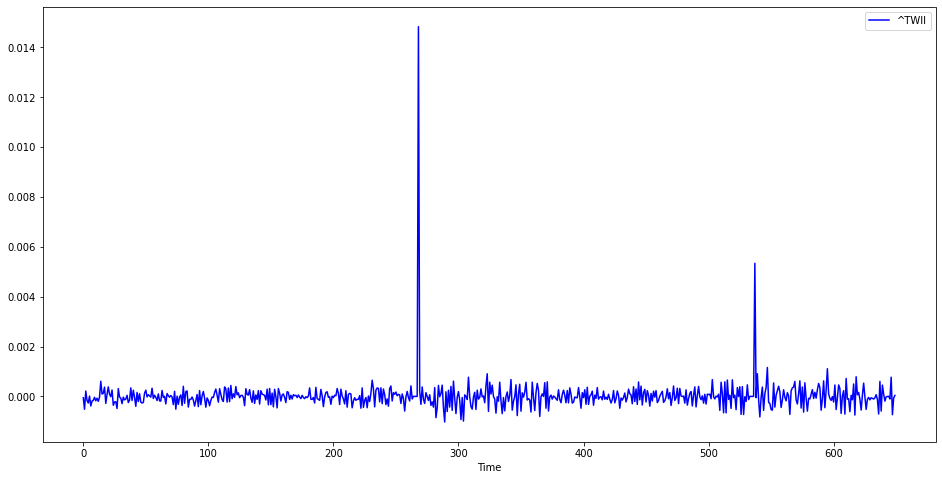

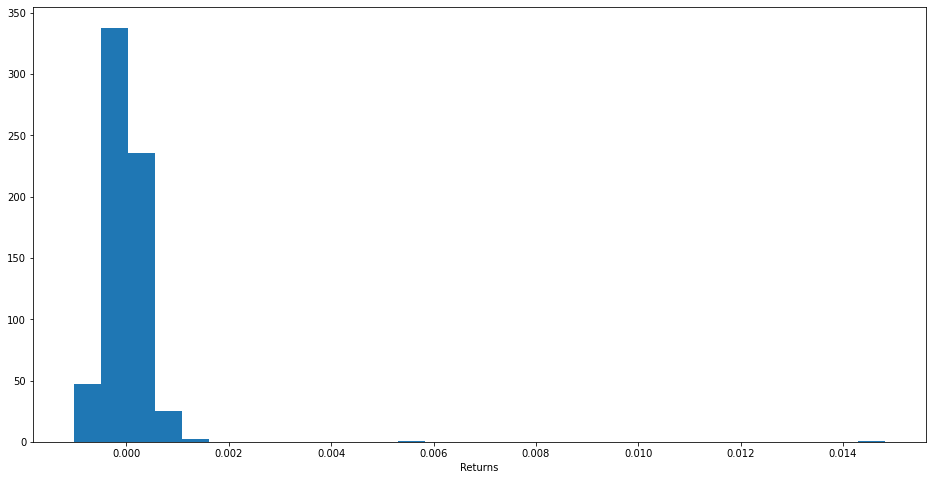

In [14]:
plt.figure(figsize=(16, 8))
plt.plot(data.values, color = 'blue', label = stock_name)  
plt.xlabel('Time')
plt.legend()
plt.show()

plt.figure(figsize=(16, 8))
plt.hist(data, bins = 30)
plt.xlabel('Returns')
plt.show()

### State creator

In [15]:
# Data -> dataset to predict from, gathered by data:loader()
# Timestep -> Day in the dataset that we want to predict for [0:datalength]
# window_size -> how many days in past we want to use to predict current status[1:datalength]
#         Try different setup to see what creates best fit
def state_creator(data, timestep, window_size):
  starting_id = timestep - window_size + 1
  
  if starting_id >= 0:
    windowed_data = data[starting_id:timestep+1]
  else:
    windowed_data = - starting_id * [data[0]] + list(data[0:timestep+1])
    
  state = []
  for i in range(window_size - 1):
    d = windowed_data[i]
    state.append(d)

  return np.array(state).reshape(-1, 1)

## Stage 5: Training the AI Trader

### Setting hyperparameters

In [16]:
window_size = 20
episodes = 200 # same as epoch
budget = len(data)

data_samples = len(data) # discard last value, that we will predict on
batch_size = (len(data) - window_size)

In [17]:
learning_rate = CustomSchedule(window_size)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98,
                                     epsilon=1e-9)

In [18]:
state_creator(data, window_size, window_size + 1).reshape(1, -1)

array([[-5.60430606e-05, -5.16601174e-04,  2.14771774e-04,
        -1.67473169e-04, -2.65547643e-04,  1.14810335e-05,
        -3.81782052e-04, -1.88601978e-04, -1.56216039e-04,
        -3.78362111e-05, -1.76521872e-04, -7.37085889e-05,
        -2.00216249e-04, -2.70200430e-05,  6.05232506e-04,
         9.40146039e-05,  1.22324591e-04,  3.71700993e-04,
        -2.79752854e-04,  7.70239859e-05]])

### Defining the Trader model

In [19]:
trader = AI_Trader(window_size, batch_size, model='TWII_ai_trader.h5')

In [20]:
# trader.model.summary()

In [21]:
# plt.figure(figsize=(8, 4))
# tf.keras.utils.plot_model(trader.model, show_shapes=True)

### Training loop

Episode: 4/200
########################
TOTAL PROFIT: - $ 3254.5. Time taken for 1 episode: 57.34 secs
########################


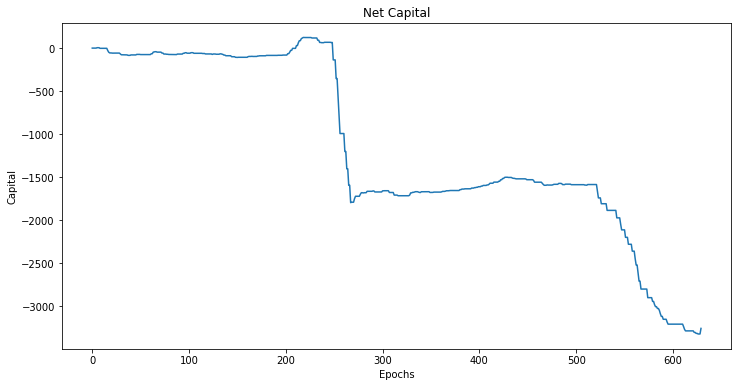

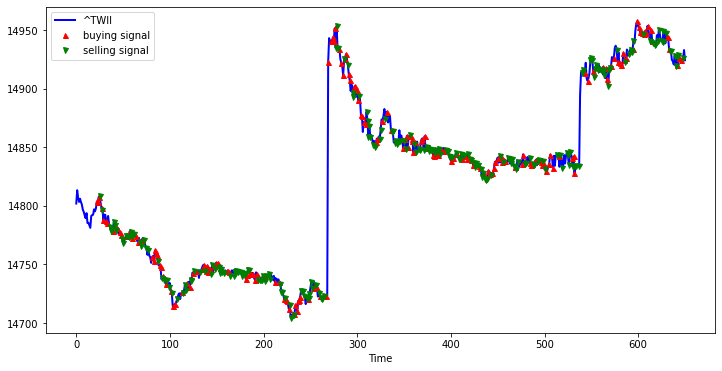

  0%|          | 0/630 [00:00<?, ?it/s]

In [ ]:
trader.reset()
trade_training_process = []
trader.performace_calculate(data, y, window_size, episodes, budget, data_samples, batch_size, trade_training_process)

In [ ]:
model_name = "{}_ai_trader.h5".format(stock_name)
trader.model.save(model_name)
files.download(model_name) 

### Profitablility Trend

In [ ]:
plt.plot(trade_training_process)
plt.title('Training Profitability')
plt.ylabel('Total Profit')
plt.xlabel('Epochs')
plt.legend(['Profit'])
plt.axhline(y = 0, color = 'red', linestyle = '-')
plt.show()

## Stage 6: Testing the AI Trader

### Loading a testing dataset

In [ ]:
# y, data1 = dataset_loader(stock_name, start_time = end_time)
y, data1 = high_frequency_dataset_loader(stock_name, period = '7d', interval = '1m')

In [ ]:
data1

In [ ]:
plt.figure(figsize=(8, 4))
plt.plot(y.values)
plt.show()

plt.figure(figsize=(8, 4))
plt.plot(data1.values)
plt.show()

plt.figure(figsize=(8, 4))
plt.hist(data1, bins = 30)
plt.show()

### Model implementation

In [ ]:
state_creator(data1, window_size+1, window_size + 1).reshape(1, -1)

In [ ]:
long_time = []
short_time = []
def model_trading(model, data, y, budget):
  long_inventory = []
  short_inventory = []
  net_capital = []
  state = state_creator(data, window_size, window_size + 1).reshape(1, -1)
  total_profit = 0
  data_samples = len(data)
  done = False
  emotion = np.array(0).reshape(-1, 1)
  long_poisition = np.array(len(long_inventory)).reshape(-1, 1)
  short_poisition = np.array(len(short_inventory)).reshape(-1, 1)
  
  for t in range(window_size, len(data)):
    if t % 100 == 0:
      clear_output(wait=True)

    if len(long_inventory) > 0:
      emotion = np.array(sum(-np.array(long_inventory) + y[t])).reshape(-1, 1)
    
    if len(short_inventory) > 0:
      emotion = np.array(sum(-np.array(short_inventory) + y[t])).reshape(-1, 1)

    p, _ = model.predict([state, emotion, long_poisition, short_poisition], verbose = 0)
    action = np.random.choice(p.shape[1], size = 1, replace = False, p = p[0])

    if action == 0 and len(long_inventory) < budget and len(short_inventory) == 0:
      long_time.append(t)
      long_inventory.append(y[t])
      print("\nAt {}/{}, AI Trader bought: ".format(t+1, data_samples), stocks_price_format(y[t]), ', Long Position Inventory: ', len(long_inventory))
    elif action == 0 and len(long_inventory) == 0 and len(short_inventory) > 0:
        long_time.append(t)
        sell_price = short_inventory.pop(0)
        p = sell_price - y[t]
        reward = p
        total_profit += p
        print("\nAt {}/{}, AI Trader closed position: ".format(t+1, data_samples), stocks_price_format(y[t]), " Profit: " + stocks_price_format(p), " Current Profit: " + stocks_price_format(total_profit))

    elif action == 1 and len(long_inventory) > 0:
      short_time.append(t)
      buy_price = long_inventory.pop(0)
      p = y[t] - buy_price
      total_profit += p
      print("\nAt {}/{}, AI Trader sold: ".format(t+1, data_samples), stocks_price_format(y[t]), " Profit: " + stocks_price_format(p), " Current Profit: " + stocks_price_format(total_profit))
      
    elif action == 1 and len(short_inventory) < budget and len(long_inventory) == 0:
      short_time.append(t)
      short_inventory.append(y[t])
      holding_times = 0
      print("\nAt {}/{}, AI Trader shorted: ".format(t+1, data_samples), stocks_price_format(y[t]), ', Short Position Inventory: ', len(short_inventory))

    else:
      print("\nAt {}/{}, AI Trader held. ".format(t+1, data_samples), " Current Profit: " + stocks_price_format(total_profit))
    if t == data_samples - 1:
      done = True
      final_p = 0
      if len(long_inventory) > 0:
        for i in long_inventory:
          final_p += y[t] - i
      elif len(short_inventory) > 0:
        for i in short_inventory:
          final_p += i - y[t]
      total_profit += final_p
      # print("\nClosed Profit {} ".format(final_p), " Current Profit: " + stocks_price_format(total_profit))

    if done:
      print("########################")
      print("TOTAL PROFIT: {}".format(total_profit))
      print("########################")
    try:
      net_capital.append(total_profit)
      next_state = state_creator(data, t + 1, window_size + 1).reshape(1, -1)
      state = next_state
    except IndexError:
      continue
  plt.plot(net_capital)
  plt.title('Net Capital')
  plt.ylabel('Capital')
  plt.xlabel('Epochs')
  plt.show()

def benchmark_random_trading(data, y, budget):
  long_inventory = []
  short_inventory = []
  net_capital = []
  state = state_creator(data, window_size, window_size + 1).reshape(1, -1)
  total_profit = 0
  data_samples = len(data)
  done = False
  emotion = np.array(0).reshape(-1, 1)
  long_poisition = np.array(len(long_inventory)).reshape(-1, 1)
  short_poisition = np.array(len(short_inventory)).reshape(-1, 1)
  
  for t in range(window_size, len(data)):
    if t % 100 == 0:
      clear_output(wait=True)

    if len(long_inventory) > 0:
      emotion = np.array(sum(-np.array(long_inventory) + y[t])).reshape(-1, 1)
    
    if len(short_inventory) > 0:
      emotion = np.array(sum(-np.array(short_inventory) + y[t])).reshape(-1, 1)

    p = np.array([[1/3, 1/3, 1/3]])
    action = np.random.choice(p.shape[1], size = 1, replace = False, p = p[0])

    if action == 0 and len(long_inventory) < budget and len(short_inventory) == 0:
      long_time.append(t)
      long_inventory.append(y[t])
      print("\nAt {}/{}, AI Trader bought: ".format(t+1, data_samples), stocks_price_format(y[t]), ', Long Position Inventory: ', len(long_inventory))
    elif action == 0 and len(long_inventory) == 0 and len(short_inventory) > 0:
        long_time.append(t)
        sell_price = short_inventory.pop(0)
        p = sell_price - y[t]
        reward = p
        total_profit += p
        print("\nAt {}/{}, AI Trader closed position: ".format(t+1, data_samples), stocks_price_format(y[t]), " Profit: " + stocks_price_format(p), " Current Profit: " + stocks_price_format(total_profit))

    elif action == 1 and len(long_inventory) > 0:
      short_time.append(t)
      buy_price = long_inventory.pop(0)
      p = y[t] - buy_price
      total_profit += p
      print("\nAt {}/{}, AI Trader sold: ".format(t+1, data_samples), stocks_price_format(y[t]), " Profit: " + stocks_price_format(p), " Current Profit: " + stocks_price_format(total_profit))
      
    elif action == 1 and len(short_inventory) < budget and len(long_inventory) == 0:
      short_time.append(t)
      short_inventory.append(y[t])
      holding_times = 0
      print("\nAt {}/{}, AI Trader shorted: ".format(t+1, data_samples), stocks_price_format(y[t]), ', Short Position Inventory: ', len(short_inventory))

    else:
      print("\nAt {}/{}, AI Trader held. ".format(t+1, data_samples), " Current Profit: " + stocks_price_format(total_profit))
    if t == data_samples - 1:
      done = True
      final_p = 0
      if len(long_inventory) > 0:
        for i in long_inventory:
          final_p += y[t] - i
      elif len(short_inventory) > 0:
        for i in short_inventory:
          final_p += i - y[t]
      total_profit += final_p
      # print("\nClosed Profit {} ".format(final_p), " Current Profit: " + stocks_price_format(total_profit))

    if done:
      print("########################")
      print("TOTAL PROFIT: {}".format(total_profit))
      print("########################")
    try:
      net_capital.append(total_profit)
      next_state = state_creator(data, t + 1, window_size + 1).reshape(1, -1)
      state = next_state
    except IndexError:
      continue
  plt.plot(net_capital)
  plt.title('Net Capital')
  plt.ylabel('Capital')
  plt.xlabel('Epochs')
  plt.show()

### Profitability visualization

In [ ]:
model_trading(trader.model, data1, y, budget = 1)

In [ ]:
plt.figure(figsize=(20,10))
plt.plot(y.values, color = 'blue', label = stock_name, lw=2.)  
plt.plot(y.values, '^', markersize=7, color='red', label = 'buying signal', markevery = long_time)
plt.plot(y.values, 'v', markersize=7, color='green', label = 'selling signal', markevery = short_time)
plt.xlabel('Time')
plt.legend()
plt.show()

In [ ]:
long_time = []
short_time = []

benchmark_random_trading(data1, y, budget = 1)

In [ ]:
plt.figure(figsize=(20,10))
plt.plot(y.values, color = 'blue', label = stock_name, lw=2.)  
plt.plot(y.values, '^', markersize=7, color='red', label = 'buying signal', markevery = long_time)
plt.plot(y.values, 'v', markersize=7, color='green', label = 'selling signal', markevery = short_time)
plt.xlabel('Time')
plt.legend()
plt.show()